In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

### Load Data

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('/Users/mcardonasanchez/Desktop/Online Courses/The-Data-Science-Course-2021-All-Resources/Other/data/acgl.us.txt', index_col='Date',
            parse_dates=['Date'])
stock_data

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2005-02-25,13.583,13.693,13.430,13.693,156240,0
2005-02-28,13.697,13.827,13.540,13.827,370509,0
2005-03-01,13.780,13.913,13.720,13.760,224484,0
2005-03-02,13.717,13.823,13.667,13.810,286431,0
2005-03-03,13.783,13.783,13.587,13.630,193824,0
...,...,...,...,...,...,...
2017-11-06,94.490,95.650,94.020,95.550,420192,0
2017-11-07,95.860,95.950,95.200,95.560,464011,0
2017-11-08,95.410,95.900,94.890,95.450,471756,0


### Visualise Data

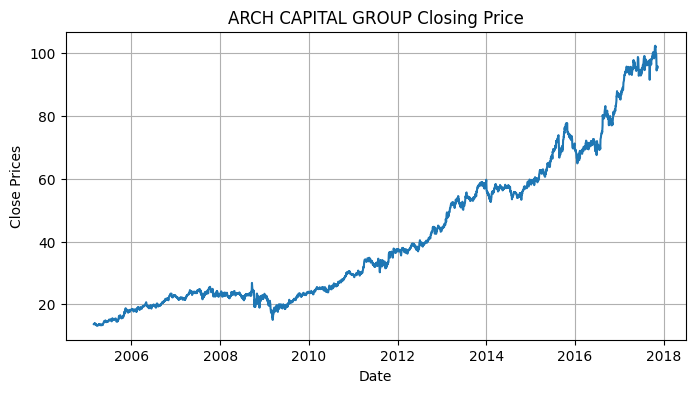

In [4]:
# plot close price
plt.figure(figsize=(8,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP Closing Price')
plt.show()

<AxesSubplot: ylabel='Density'>

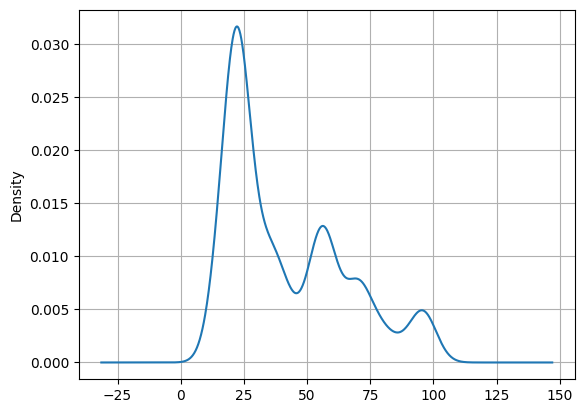

In [6]:
# Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde', grid='On')

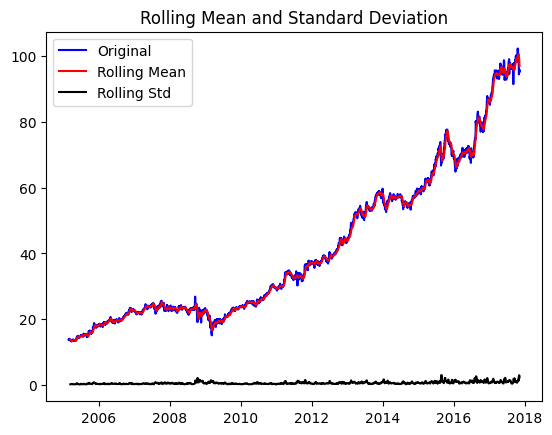

Results of Dickey-Fuller Test
Test Statistics             1.374899
p-value                     0.996997
No. lags used               5.000000
No. observations used    3195.000000
critical value (1%)        -3.432398
critical value (5%)        -2.862445
critical value (10%)       -2.567252
dtype: float64


In [8]:
# Test for Stationarity
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print('Results of Dickey-Fuller Test')
    adft = adfuller(timeseries, autolag='AIC')
    # output for dft will give us without defining what the values are
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. lags used', 'No. observations used'])
    for key, values in adft[4].items():
        output['critical value (%s)'%key] = values
    print(output)

test_stationarity(df_close)


<Figure size 640x480 with 0 Axes>

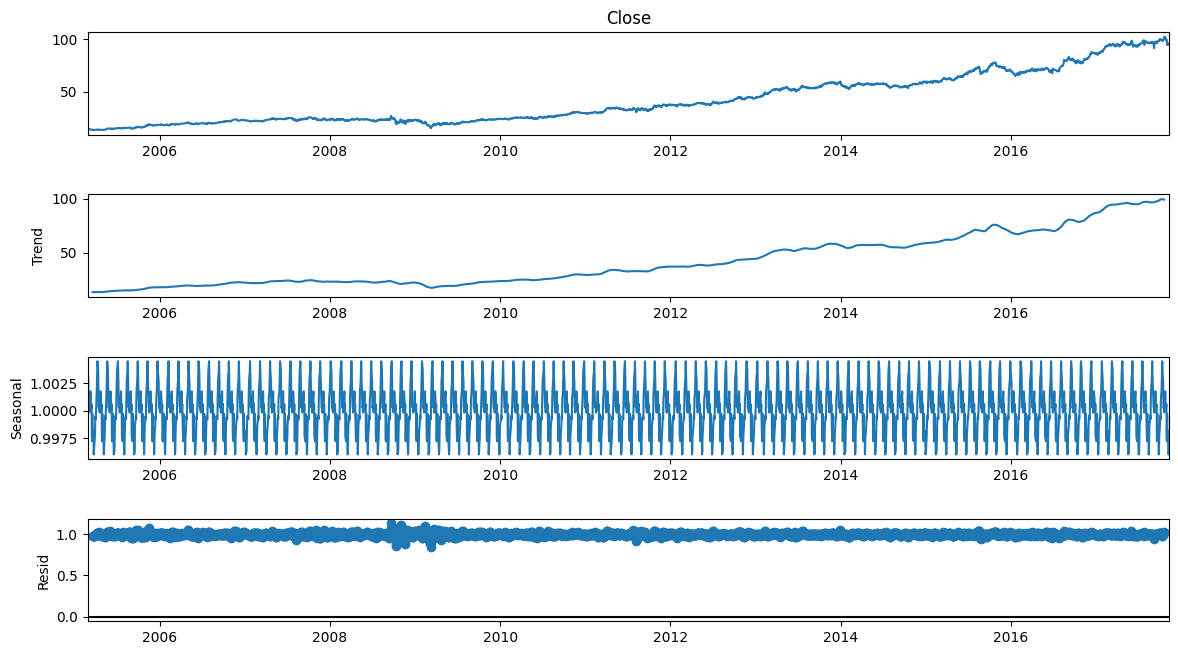

In [23]:
# Isolate the trend and seasonality from a time series
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(13,7)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


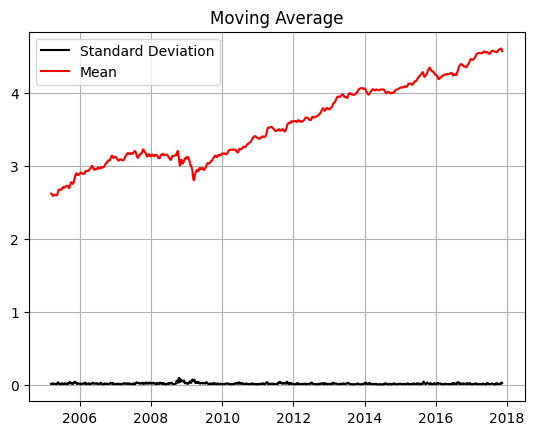

In [30]:
# eliminate trend
# from pylab import rcParams
# rcParams['figure.fisize'] = 8,4
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color='black', label='Standard Deviation')
plt.plot(moving_avg, color='red', label='Mean')
plt.legend()
plt.grid(True)
plt.show()

### ARIMA

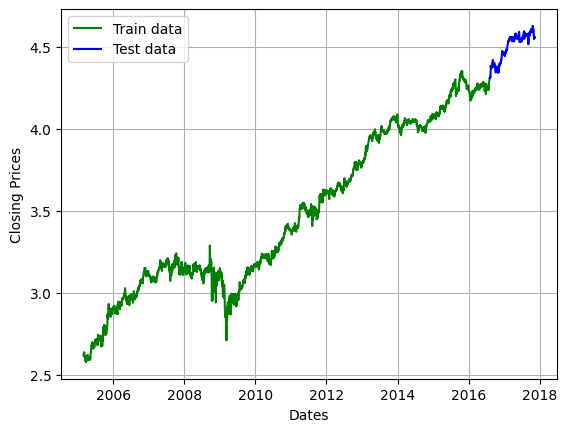

In [32]:
# split into train and test set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure()
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16491.508, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16525.992, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16527.964, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16488.323, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16527.157, Time=1.97 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16527.120, Time=1.96 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16528.810, Time=2.38 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-16526.020, Time=2.48 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16524.974, Time=1.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16525.435, Time=1.02 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-16516.417, Time=0.80 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-16527.597, Time=0.66 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 17.657 seconds
  

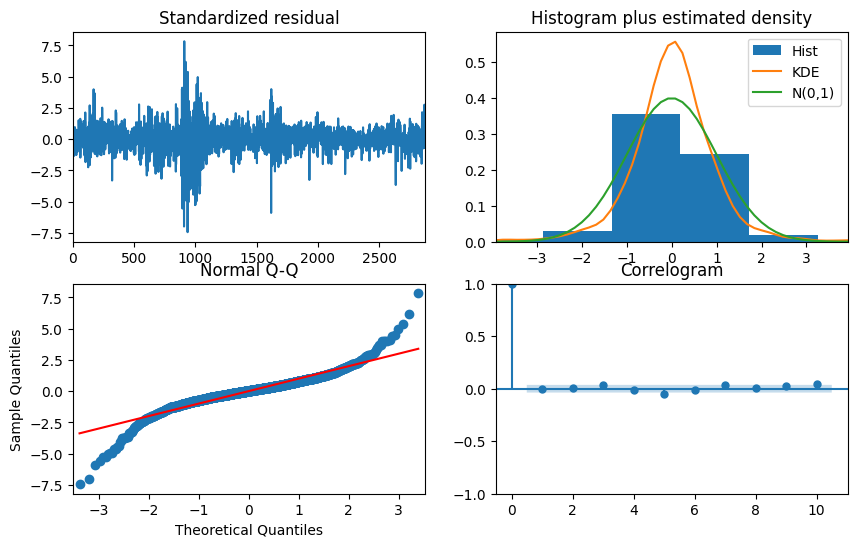

In [34]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                             test='adf', # use adftest to find optimal 'd'
                             max_p=3, max_q=3, # maximum p and q
                             m=1, # frequency of series
                             d=None, # let model determine 'd'
                             seasonal=False, # No seasonality
                             start_P=0,
                             D=0,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(10,6))
plt.show()

In [35]:
print(model_autoARIMA.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2877
Model:               SARIMAX(1, 1, 2)   Log Likelihood                8269.405
Date:                Fri, 05 May 2023   AIC                         -16528.810
Time:                        13:20:36   BIC                         -16498.989
Sample:                             0   HQIC                        -16518.061
                               - 2877                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.467e-05   7.12e-06      3.464      0.001    1.07e-05    3.86e-05
ar.L1          0.9538      0.009    104.140      0.000       0.936       0.972
ma.L1         -1.0708      0.015    -73.566      0.0

In [42]:
fitted = model_autoARIMA.fit(train_data)

/Users/mcardonasanchez/Desktop/Online Courses/The-Data-Science-Course-2021-All-Resources/ds-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


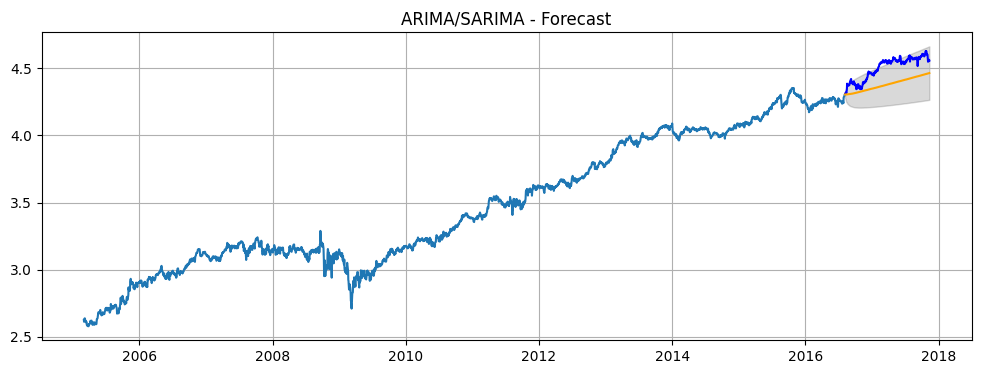

MSE: 0.017121534999729876
MAE: 0.12244869576664315
RMSE: 0.1308492835277667
MAPE: 0.02703049970735103


In [63]:
def forecast(ARIMA_model, periods=321):
    # forecast
    fitted, confint = ARIMA_model.predict(n_periods=periods, return_conf_int=True)

    # make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=test_data.index)
    lower_series = pd.Series(confint[:,0], index=test_data.index)
    upper_series = pd.Series(confint[:,1], index=test_data.index)

    # plot
    plt.figure(figsize=(12,4))
    plt.plot(train_data, label='training data')
    plt.plot(test_data, color='blue', label='Actual Stock Price')
    plt.plot(fitted_series, color='orange', label='Predicted Stock Price')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast")
    plt.grid(True)
    plt.show()

    # report performance
    fc = fitted_series
    mse = mean_squared_error(test_data, fc)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(test_data, fc)
    print('MAE: '+str(mae))
    rmse = math.sqrt(mean_squared_error(test_data, fc))
    print('RMSE: '+str(rmse))
    mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
    print('MAPE: '+str(mape))


forecast(model_autoARIMA)